In [2]:
# Helper libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import json
import requests

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from scipy import sparse
from scipy.sparse import coo_matrix

import tensorrec

import nltk
from ast import literal_eval

## User data

In [4]:
# import user information
user_info = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', delimiter='\t', encoding='utf-8')
user_info.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [7]:
# view missing information
user_info.isna().sum()

#id             0
gender        108
age           706
country        85
registered      8
dtype: int64

In [8]:
# map user with an ID in a dictionary for easy access
user_index = {}
user_index = {k: v for v, k in enumerate(user_info['#id'].values)}
index_user = {}
index_user = {idx: user for user, idx in user_index.items()}

### Cleaning user data

In [9]:
# treating gender missing values as a third gender
user_info['gender'].fillna('Non', inplace=True)

In [10]:
# treating age missing values as zero
user_info['age'].fillna(0, inplace=True)

In [11]:
# treating country missing values as another country
user_info['country'].fillna('Non', inplace=True)

### Creating user features

#### 1. Age

In [12]:
# converting float values of age to integer
user_info['age'] = pd.to_numeric(user_info['age'], downcast='signed')

In [13]:
# creating 4 categories of age range
d = {range(21): 0, range(21, 31): 1, range(31, 41): 3, range(41,user_info['age'].max()+1): 4 }

In [14]:
# apply range categories to users
user_info['age_range'] = user_info['age'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
user_info.head()

,#id,gender,age,country,registered,age_range
0,user_000001,m,0,Japan,"Aug 13, 2006",0
1,user_000002,f,0,Peru,"Feb 24, 2006",0
2,user_000003,m,22,United States,"Oct 30, 2005",1
3,user_000004,f,0,Non,"Apr 26, 2006",0
4,user_000005,m,0,Bulgaria,"Jun 29, 2006",0


#### 2. Country

In [15]:
# read file containing relationship between countries and continents
locations = pd.read_csv('countriescontinents.csv')
locations['Continent'].unique()

array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], dtype=object)

In [16]:
# setting country as index for easier replacement
locations = locations.set_index("Country")["Continent"]
locations.head()

Country
Algeria     Africa
Angola      Africa
Benin       Africa
Botswana    Africa
Burkina     Africa
Name: Continent, dtype: object

In [17]:
# save continent value equivalent in another column
user_info['continent'] = user_info['country']
user_info['continent'].replace(locations, inplace=True)
user_info.head()

,#id,gender,age,country,registered,age_range,continent
0,user_000001,m,0,Japan,"Aug 13, 2006",0,Asia
1,user_000002,f,0,Peru,"Feb 24, 2006",0,South America
2,user_000003,m,22,United States,"Oct 30, 2005",1,United States
3,user_000004,f,0,Non,"Apr 26, 2006",0,Non
4,user_000005,m,0,Bulgaria,"Jun 29, 2006",0,Europe


In [18]:
user_info['continent'].unique()

array(['Asia', 'South America', 'United States', 'Non', 'Europe',
       "Cote D'Ivoire", 'Africa', 'North America', 'Oceania',
       'United States Minor Outlying Islands', 'Czech Republic',
       'Antarctica', "Korea, Democratic People's Republic of",
       'Congo, the Democratic Republic of the',
       'British Indian Ocean Territory', 'Netherlands Antilles',
       'Northern Mariana Islands'], dtype=object)

### Creating user embeddings

In [19]:
user_features = user_info[["gender","age_range","continent"]].values
user_features

array([['m', 0, 'Asia'],
       ['f', 0, 'South America'],
       ['m', 1, 'United States'],
       ...,
       ['m', 0, 'Europe'],
       ['f', 0, 'Europe'],
       ['m', 0, 'United States']], dtype=object)

#### 1. Label Encoder

In [20]:
enc = OrdinalEncoder()
enc.fit(user_features)

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [21]:
user_features_array = enc.fit_transform(user_features)
n_features = user_features_array.shape[1]
user_features_array.shape

(992, 3)

In [22]:
enc.categories_

[array(['Non', 'f', 'm'], dtype=object),
 array([0, 1, 3, 4], dtype=object),
 array(['Africa', 'Antarctica', 'Asia', 'British Indian Ocean Territory',
        'Congo, the Democratic Republic of the', "Cote D'Ivoire",
        'Czech Republic', 'Europe',
        "Korea, Democratic People's Republic of", 'Netherlands Antilles',
        'Non', 'North America', 'Northern Mariana Islands', 'Oceania',
        'South America', 'United States',
        'United States Minor Outlying Islands'], dtype=object)]

In [23]:
user_data_features = sparse.coo_matrix(user_features_array)
user_data_features.toarray()

array([[ 2.,  0.,  2.],
       [ 1.,  0., 14.],
       [ 2.,  1., 15.],
       ...,
       [ 2.,  0.,  7.],
       [ 1.,  0.,  7.],
       [ 2.,  0., 15.]])

#### 2. One Hot Encoder

In [24]:
enc = OneHotEncoder()
enc.fit(user_features)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [25]:
user_features_onehot = enc.fit_transform(user_features)
n_features_onehot = user_features_onehot.shape[1]
user_features_onehot.shape

(992, 24)

In [26]:
user_data_features_onehot = sparse.coo_matrix(user_features_onehot)
user_data_features_onehot.toarray()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

## Song data

In [27]:
# importing user history with songs
user_interactions = pd.read_csv('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',
                         delimiter='\t',
                         encoding='utf-8',
                         error_bad_lines=False,
                        names=['userid','timestamp','artid','artname','traid','traname'])
user_interactions.head()

,userid,timestamp,artid,artname,traid,traname
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [28]:
# number of times a user has listen to each song
listencount = user_interactions.groupby(['userid', 'traname','artname']).count()[['timestamp']]
listencount.rename(columns={"timestamp": "listen_count_by_person"}, inplace=True)
listencount.reset_index(inplace=True) 

In [29]:
listencount['song'] = listencount['traname'] + ' - ' + listencount['artname']
listencount.head()

,userid,traname,artname,listen_count_by_person,song
0,user_000001,'84 Pontiac Dream,Boards Of Canada,14,'84 Pontiac Dream - Boards Of Canada
1,user_000001,(All I Wanted Was To Make You) Feel Good,Bugge Wesseltoft,3,(All I Wanted Was To Make You) Feel Good - Bug...
2,user_000001,(D)Ecaying Beauty,Richie Hawtin,1,(D)Ecaying Beauty - Richie Hawtin
3,user_000001,(Far From) Home,Tiga,1,(Far From) Home - Tiga
4,user_000001,(Get Off Your) High Horse Lady,Oasis,1,(Get Off Your) High Horse Lady - Oasis


In [30]:
listencount.shape

(4613461, 5)

### Clean song data

In [31]:
# group by users per unique pair of song title and artist
users_per_song = listencount.groupby(['traname','artname']).size().reset_index(name='users_per_song')
users_per_song['song'] = users_per_song['traname'] + ' - ' + users_per_song['artname']
users_per_song.head()

,traname,artname,users_per_song,song
0,戀上你是書中主角 The Library,Inlove,1,戀上你是書中主角 The Library - Inlove
1,,"!;04:&Gt;56:0, @C&Lt;0=, 654",1,"- !;04:&Gt;56:0, @C&Lt;0=, 654"
2,~Kuuhaku~,Panic☆Ch,1,~Kuuhaku~ - Panic☆Ch
3,~Kuuhaku~,パニックちゃんねる,1,~Kuuhaku~ - パニックちゃんねる
4,M.A.K.E.L.O.V.E.T.O.M.E (Mazerati Mix),Channel 7 Featuring Vanessa Carlton,1,M.A.K.E.L.O.V.E.T.O.M.E (Mazerati Mix) - Ch...


In [32]:
users_per_song.shape

(1498950, 4)

In [33]:
# threshold of users per song, below are ignored
threshold_users_per_song = 10
mask = users_per_song[['song','users_per_song']].loc[users_per_song['users_per_song'] > threshold_users_per_song]
mask.shape # total number of unique pair of song title and artist

(72264, 2)

In [34]:
mask.head()

,song,users_per_song
9,! (Foreword) - Pain Of Salvation,11
86,#1 - Animal Collective,56
111,#1 Crush - Garbage,63
125,#1 Hit Jam - The Brian Jonestown Massacre,18
127,#1 Hit Song - Minutemen,18


In [35]:
# cleaning the user listening history, keeping only the songs above 10 listeners
clean_user_tracks = listencount[listencount['song'].isin(mask['song'])].copy()
clean_user_tracks.head()

,userid,traname,artname,listen_count_by_person,song
0,user_000001,'84 Pontiac Dream,Boards Of Canada,14,'84 Pontiac Dream - Boards Of Canada
3,user_000001,(Far From) Home,Tiga,1,(Far From) Home - Tiga
4,user_000001,(Get Off Your) High Horse Lady,Oasis,1,(Get Off Your) High Horse Lady - Oasis
6,user_000001,(Nice Dream),Radiohead,1,(Nice Dream) - Radiohead
20,user_000001,15 Step,Radiohead,24,15 Step - Radiohead


In [36]:
# records were reduced by 2 million and a half
clean_user_tracks.shape

(2071360, 5)

In [37]:
# map song title to an ID in a dictionary for easy access
song_index = {}
song_index = {k: v for v, k in enumerate(mask['song'].values)}
index_song = {}
index_song = {idx: song for song, idx in song_index.items()}

In [38]:
index_song[0]

'! (Foreword) - Pain Of Salvation'

### Getting song tags

In [39]:
songs_tags = pd.read_csv('songs_tags.csv')
songs_tags.head()

,song,tags
0,! (Foreword) - Pain Of Salvation,"['progressive metal', 'progressive rock', 'met..."
1,#1 - Animal Collective,[]
2,#1 Crush - Garbage,[]
3,#1 Hit Jam - The Brian Jonestown Massacre,[]
4,#1 Hit Song - Minutemen,[]


In [40]:
# dictionary of relationship between songs and tags
song_tags_dict = songs_tags.set_index('song').T.to_dict('list')

In [41]:
# getting all the unique pair of songs and artist to assign tags
lps = clean_user_tracks.groupby(['traname','artname']).size().reset_index(name='listeners_per_song')
lps['song'] = lps['traname'] + ' - ' + lps['artname']
lps.head()

,traname,artname,listeners_per_song,song
0,! (Foreword),Pain Of Salvation,11,! (Foreword) - Pain Of Salvation
1,#1,Animal Collective,56,#1 - Animal Collective
2,#1 Crush,Garbage,63,#1 Crush - Garbage
3,#1 Hit Jam,The Brian Jonestown Massacre,18,#1 Hit Jam - The Brian Jonestown Massacre
4,#1 Hit Song,Minutemen,18,#1 Hit Song - Minutemen


In [42]:
# assigning tags to songs in the dataframe
lps['tags'] = songs_tags['tags']
lps['tags'] = lps.tags.apply(lambda x: literal_eval(str(x))) # removing string from array when importing
lps.head()

,traname,artname,listeners_per_song,song,tags
0,! (Foreword),Pain Of Salvation,11,! (Foreword) - Pain Of Salvation,"[progressive metal, progressive rock, metal, p..."
1,#1,Animal Collective,56,#1 - Animal Collective,[]
2,#1 Crush,Garbage,63,#1 Crush - Garbage,[]
3,#1 Hit Jam,The Brian Jonestown Massacre,18,#1 Hit Jam - The Brian Jonestown Massacre,[]
4,#1 Hit Song,Minutemen,18,#1 Hit Song - Minutemen,[]


### Creating song embeddings

In [48]:
# Getting all tags in a list of list
tags_list = list(lps['tags'].values)
tags_list[:5]

[['progressive metal',
  'progressive rock',
  'metal',
  'progressive',
  'rock',
  'swedish metal',
  'godly singing',
  'heavy metal',
  'seen live',
  'swedish'],
 [],
 [],
 [],
 []]

In [49]:
# get all unique tags in a list
# THIS TAKES A LOT TO RUN, MANY TAGS AHHH
all_tags = sum(tags_list,[])
unique_tags = set(all_tags)

In [50]:
# A lot of unique tags, we need to reduce this
len(unique_tags)

27745

In [51]:
all_tags_freq = nltk.FreqDist(all_tags)
all_tags_freq

FreqDist({'rock': 36082, 'alternative': 26846, 'indie': 23692, 'pop': 14444, 'alternative rock': 14440, 'electronic': 14412, 'indie rock': 13105, 'female vocalists': 10244, 'british': 10066, 'electronica': 8437, ...})

In [52]:
all_tags_df = pd.DataFrame({'Tag': list(all_tags_freq.keys()), 
                              'Count': list(all_tags_freq.values())})

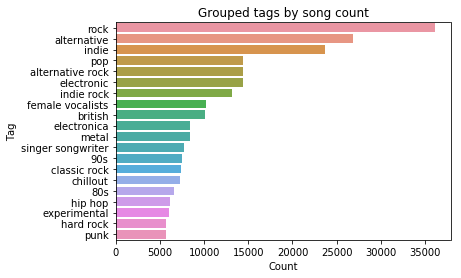

In [120]:
# let's get the 50 more popular tags
g = all_tags_df.nlargest(columns="Count", n = 20) 
plt.title("Grouped tags by song count") 
ax = sns.barplot(data=g, x= "Count", y = "Tag") 
ax.set(ylabel = 'Tag') 
plt.show()

In [54]:
# 100 tags only
tags_array_r = g['Tag'].values

In [55]:
res = []
for tags in tags_list:
    filter_tags = []
    for tag in tags:
        if tag in tags_array_r:
            filter_tags.append(tag)
    res.append(filter_tags)

In [56]:
lps['filter_tags'] = res

In [57]:
lps.head()

,traname,artname,listeners_per_song,song,tags,filter_tags
0,! (Foreword),Pain Of Salvation,11,! (Foreword) - Pain Of Salvation,"[progressive metal, progressive rock, metal, p...","[progressive metal, progressive rock, metal, p..."
1,#1,Animal Collective,56,#1 - Animal Collective,[],[]
2,#1 Crush,Garbage,63,#1 Crush - Garbage,[],[]
3,#1 Hit Jam,The Brian Jonestown Massacre,18,#1 Hit Jam - The Brian Jonestown Massacre,[],[]
4,#1 Hit Song,Minutemen,18,#1 Hit Song - Minutemen,[],[]


In [58]:
mlb = MultiLabelBinarizer()
tag_features = mlb.fit_transform(res)
n_tags = tag_features.shape[1]

In [59]:
tag_features[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [60]:
mlb.classes_

array(['00s', '60s', '70s', '80s', '90s', 'acoustic', 'alternative',
       'alternative metal', 'alternative rock', 'ambient', 'american',
       'awesome', 'beautiful', 'blues', 'blues rock', 'british',
       'british i like', 'britpop', 'canadian', 'chill', 'chillout',
       'classic rock', 'cover', 'covers', 'dance', 'death metal',
       'downtempo', 'electro', 'electronic', 'electronica', 'emo', 'epic',
       'experimental', 'favorites', 'female vocalist', 'female vocalists',
       'folk', 'folk rock', 'french', 'funk', 'gothic', 'gothic metal',
       'grunge', 'guitar', 'happy', 'hard rock', 'hardcore',
       'heard on pandora', 'heavy metal', 'hip hop', 'house', 'idm',
       'indie', 'indie pop', 'indie rock', 'industrial', 'instrumental',
       'jazz', 'lo fi', 'lounge', 'love', 'male vocalists', 'melancholy',
       'mellow', 'melodic death metal', 'metal', 'new wave', 'nu metal',
       'oldies', 'piano', 'pop', 'pop punk', 'pop rock', 'post hardcore',
       'post p

In [61]:
# convert tags to dictionary
tag_index = {}
tag_index = {k: v for v, k in enumerate(mlb.classes_)}
index_tag = {}
index_tag = {idx: tag for tag, idx in tag_index.items()}

In [62]:
tag_index['pop punk']

71

In [63]:
song_tag_features = sparse.coo_matrix(tag_features)
song_tag_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Interactions embeddings

In [64]:
# all the user with their respective listening history
clean_user_tracks.head()

,userid,traname,artname,listen_count_by_person,song
0,user_000001,'84 Pontiac Dream,Boards Of Canada,14,'84 Pontiac Dream - Boards Of Canada
3,user_000001,(Far From) Home,Tiga,1,(Far From) Home - Tiga
4,user_000001,(Get Off Your) High Horse Lady,Oasis,1,(Get Off Your) High Horse Lady - Oasis
6,user_000001,(Nice Dream),Radiohead,1,(Nice Dream) - Radiohead
20,user_000001,15 Step,Radiohead,24,15 Step - Radiohead


In [65]:
clean_user_tracks['user_id'] = clean_user_tracks['userid'].map(user_index)
clean_user_tracks['song_id'] = clean_user_tracks['song'].map(song_index)
clean_user_tracks.head()

,userid,traname,artname,listen_count_by_person,song,user_id,song_id
0,user_000001,'84 Pontiac Dream,Boards Of Canada,14,'84 Pontiac Dream - Boards Of Canada,0,22
3,user_000001,(Far From) Home,Tiga,1,(Far From) Home - Tiga,0,74
4,user_000001,(Get Off Your) High Horse Lady,Oasis,1,(Get Off Your) High Horse Lady - Oasis,0,79
6,user_000001,(Nice Dream),Radiohead,1,(Nice Dream) - Radiohead,0,142
20,user_000001,15 Step,Radiohead,24,15 Step - Radiohead,0,421


In [66]:
# creating arrays of unique users and songs
user_array = clean_user_tracks['user_id'].unique()
song_array = clean_user_tracks['song'].unique()

In [67]:
n_users = len(user_array)+1
n_users

992

In [68]:
n_items = len(song_array)
n_items

72264

In [69]:
ratings = clean_user_tracks[['user_id', 'song_id', 'listen_count_by_person']].values
ratings

array([[    0,    22,    14],
       [    0,    74,     1],
       [    0,    79,     1],
       ...,
       [  991, 72201,     1],
       [  991, 72242,     1],
       [  991, 72243,    10]])

In [70]:
# This method converts a list of (user, item, rating) to a sparse matrix
def interactions_list_to_sparse_matrix(interactions):
    users_column, items_column, ratings_column = zip(*interactions)
    return sparse.coo_matrix((ratings_column, (users_column, items_column)),shape=(n_users, n_items))

In [71]:
train_ratings, test_ratings = train_test_split(ratings, test_size=0.20, random_state=42)
print("{} train ratings, {} test ratings".format(len(train_ratings), len(test_ratings)))

1657088 train ratings, 414272 test ratings


In [72]:
# Create sparse matrices of interaction data
sparse_train_ratings = interactions_list_to_sparse_matrix(train_ratings)
sparse_test_ratings = interactions_list_to_sparse_matrix(test_ratings)

In [73]:
sparse_train_ratings.shape

(992, 72264)

In [74]:
item_indicator_features = sparse.identity(n_items)
user_indicator_features = sparse.identity(n_users)

## Model

### 1. Collaborative Filtering

In [75]:
recall_results = {}

In [76]:
# Build the model with default parameters
model = tensorrec.TensorRec(n_components=5)

In [77]:
# Fit the collaborative filter model
print("Training collaborative filter")
model.fit(interactions=sparse_train_ratings,
             user_features=user_indicator_features,
             item_features=item_indicator_features)

Training collaborative filter


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [78]:
# Create sets of train/test interactions that are only ratings >= 10
sparse_train_ratings_10plus = sparse_train_ratings.multiply(sparse_train_ratings >= 10)
sparse_test_ratings_10plus = sparse_test_ratings.multiply(sparse_test_ratings >= 10)

In [79]:
# This method consumes item ranks for each user and prints out recall@10 train/test metrics
def check_results(ranks):
    train_recall_at_10 = tensorrec.eval.recall_at_k(
        test_interactions=sparse_train_ratings_10plus,
        predicted_ranks=ranks,
        k=50
    ).mean()
    test_recall_at_10 = tensorrec.eval.recall_at_k(
        test_interactions=sparse_test_ratings_10plus,
        predicted_ranks=ranks,
        k=50
    ).mean()
    print("Recall at 10: Train: {:.4f} Test: {:.4f}".format(train_recall_at_10,
                                                            test_recall_at_10))
    return(train_recall_at_10,test_recall_at_10)

In [80]:
# Check the results of the MF CF model
print("Matrix factorization collaborative filter:")
predicted_ranks = model.predict_rank(user_features=user_indicator_features,
                                        item_features=item_indicator_features)

Matrix factorization collaborative filter:


In [81]:
recall_results['Collaborative Filtering'] = check_results(predicted_ranks)

Recall at 10: Train: 0.0112 Test: 0.0050


#### Changing loss function

In [82]:
# Let's try a new loss function: WMRB
print("Training collaborative filter with WMRB loss")
ranking_cf_model = tensorrec.TensorRec(n_components=5,
                                       loss_graph=tensorrec.loss_graphs.WMRBLossGraph())
ranking_cf_model.fit(interactions=sparse_train_ratings_10plus,
                     user_features=user_indicator_features,
                     item_features=item_indicator_features,
                     n_sampled_items=int(n_items * .01))

Training collaborative filter with WMRB loss


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [83]:
# Check the results of the WMRB MF CF model
print("WMRB matrix factorization collaborative filter:")
predicted_ranks = ranking_cf_model.predict_rank(user_features=user_indicator_features,
                                                item_features=item_indicator_features)
recall_results['CF WMRB'] = check_results(predicted_ranks)

WMRB matrix factorization collaborative filter:
Recall at 10: Train: 0.0575 Test: 0.0318


### 2. Content-based filtering

#### Using item features

In [84]:
# Fit a content-based model using the song tags as item features
print("Training content-based recommender")
content_model_item = tensorrec.TensorRec(
    n_components=n_tags,
    item_repr_graph=tensorrec.representation_graphs.FeaturePassThroughRepresentationGraph(),
    loss_graph=tensorrec.loss_graphs.WMRBLossGraph()
)
content_model_item.fit(interactions=sparse_train_ratings_10plus,
                  user_features=user_indicator_features,
                  item_features=song_tag_features,
                  n_sampled_items=int(n_tags * .01))

Training content-based recommender


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [85]:
# Check the results of the content-based model
print("Content-based recommender:")
predicted_ranks = content_model_item.predict_rank(user_features=user_indicator_features,
                                             item_features=song_tag_features)
recall_results['CB ITEM'] = check_results(predicted_ranks)

Content-based recommender:
Recall at 10: Train: 0.0262 Test: 0.0201


#### Using song features one-hot encoding

In [86]:
# Fit a content-based model using the user features
print("Training content-based recommender")
content_model_user = tensorrec.TensorRec(
    n_components=n_features_onehot,
    user_repr_graph=tensorrec.representation_graphs.FeaturePassThroughRepresentationGraph(),
    loss_graph=tensorrec.loss_graphs.WMRBLossGraph()
)
content_model_user.fit(interactions=sparse_train_ratings_10plus,
                  user_features=user_data_features_onehot,
                  item_features=item_indicator_features,
                  n_sampled_items=int(n_features_onehot * .1))

Training content-based recommender


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [87]:
# Check the results of the content-based model
print("Content-based recommender:")
predicted_ranks = content_model_user.predict_rank(user_features=user_data_features_onehot,
                                             item_features=item_indicator_features)
recall_results['CB USER1'] = check_results(predicted_ranks)

Content-based recommender:
Recall at 10: Train: 0.0126 Test: 0.0057


#### Using user features label encoding

In [88]:
# Fit a content-based model using the user features
print("Training content-based recommender")
content_model_user_label = tensorrec.TensorRec(
    n_components=user_data_features.shape[1],
    user_repr_graph=tensorrec.representation_graphs.FeaturePassThroughRepresentationGraph(),
    loss_graph=tensorrec.loss_graphs.WMRBLossGraph()
)
content_model_user_label.fit(interactions=sparse_train_ratings_10plus,
                  user_features=user_data_features,
                  item_features=item_indicator_features,
                  n_sampled_items=int(user_data_features.shape[1]))

Training content-based recommender


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [89]:
# Check the results of the content-based model
print("Content-based recommender:")
predicted_ranks = content_model_user_label.predict_rank(user_features=user_data_features,
                                             item_features=item_indicator_features)
recall_results['CB USER LABEL'] = check_results(predicted_ranks)

Content-based recommender:
Recall at 10: Train: 0.0068 Test: 0.0049


### 3. Hybrid approach

In [90]:
# Concatenate features with indicator features for hybrid recommender system
full_item_features = sparse.hstack([item_indicator_features, song_tag_features])
full_user_features = sparse.hstack([user_indicator_features, user_data_features_onehot])

In [106]:
print("Training hybrid recommender")
hybrid_model = tensorrec.TensorRec(
    n_components=5,
    loss_graph=tensorrec.loss_graphs.WMRBLossGraph()
)
hybrid_model.fit(interactions=sparse_train_ratings_10plus,
                 user_features=user_indicator_features,
                 item_features=full_item_features,
                 n_sampled_items=int(n_tags * .01))

Training hybrid recommender


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [109]:
print("Hybrid recommender:")
predicted_ranks = hybrid_model.predict_rank(user_features=user_indicator_features,
                                            item_features=full_item_features)
recall_results['HYBRID'] = check_results(predicted_ranks)

Hybrid recommender:
Recall at 10: Train: 0.0111 Test: 0.0107


### 4. Deep Learning approach

In [93]:
print("Deep Learning Recommender")
dl_model = tensorrec.TensorRec(
    n_components=n_tags,
    loss_graph=tensorrec.loss_graphs.WMRBLossGraph(),
    user_repr_graph=tensorrec.representation_graphs.ReLURepresentationGraph(),
    item_repr_graph=tensorrec.representation_graphs.ReLURepresentationGraph())

Deep Learning Recommender


In [94]:
dl_model.fit(interactions=sparse_train_ratings_10plus,
                 user_features=user_indicator_features,
                 item_features=full_item_features,
                 n_sampled_items=int(n_tags * .01))

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

In [110]:
print("Deep Learning recommender system:")
predicted_ranks_dl = dl_model.predict_rank(user_features=user_indicator_features,
                                            item_features=full_item_features)
recall_results['DL'] = check_results(predicted_ranks_dl)

Deep Learning recommender system:
Recall at 10: Train: 0.0006 Test: 0.0004


In [111]:
recall_results

{'Collaborative Filtering': (0.011246022516353864, 0.004988313137182935),
 'CF WMRB': (0.05750904127533483, 0.03182355641412479),
 'CB ITEM': (0.026208644841632572, 0.020089778813074378),
 'CB USER1': (0.012568215177222362, 0.005733221840017423),
 'CB USER LABEL': (0.006788851300724196, 0.004892538044779395),
 'HYBRID': (0.011124971814488557, 0.010651961349318619),
 'DL': (0.0005751228631409415, 0.0004088366095808695)}

In [112]:
results = pd.DataFrame.from_dict(recall_results, orient='index', columns=['TRAIN','TEST'])
results

,TRAIN,TEST
Collaborative Filtering,0.011246,0.004988
CF WMRB,0.057509,0.031824
CB ITEM,0.026209,0.020090
CB USER1,0.012568,0.005733
CB USER LABEL,0.006789,0.004893
HYBRID,0.011125,0.010652
DL,0.000575,0.000409


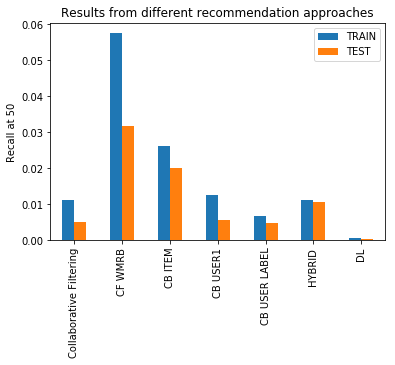

In [113]:
results.plot(kind='bar',title='Results from different recommendation approaches');
plt.ylabel('Recall at 50')
plt.show();